# Stroke Prediction Using Deep Learning-Based Logistic Regression.

This project leverages deep learning techniques—specifically, a logistic regression model built with PyTorch—to predict the likelihood of stroke occurrence based on demographic and health-related categorical and continuous variables. The dataset includes attributes such as age, gender, hypertension, heart disease, marital status, work type, residence type, and smoking status.

Key Objectives:

Perform extensive data cleaning, exploration, and feature engineering.

Normalize and encode categorical features appropriately for neural network modeling.

Train a deep learning-based binary classification model using logistic regression with sigmoid activation.

Evaluate model performance using loss curves and classification metrics like accuracy.

Visualize and interpret the relationship between individual predictors and the target variable (`stroke`) using crosstab tables and bar charts.

In [1]:
# The packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Connecting to datasource and overview

In [2]:
# Dataset 
url = url = "https://raw.githubusercontent.com/karavokyrismichail/Stroke-Prediction---Random-Forest/main/healthcare-dataset-stroke-data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print(f"Shape of dataset: {df.shape}")

Shape of dataset: (5110, 12)


 Shape is (5110, 12) — 5110 samples, 11 features + 1 target (stroke)

In [4]:
# Missing values and data types
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_marr

The *body mass index-bmi* column is the only column with missing values.

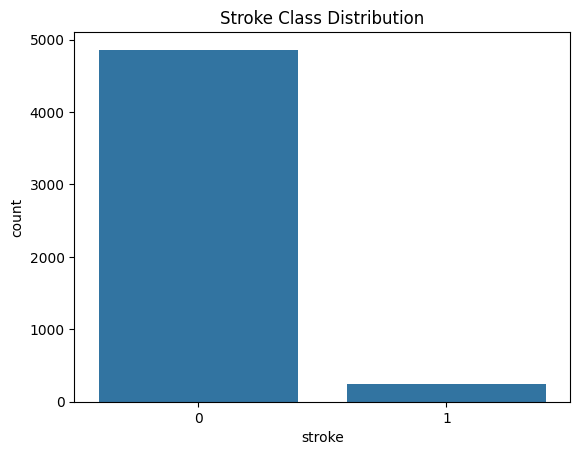

In [5]:
# Class distribution (target variable)
sns.countplot(x='stroke', data=df)
plt.title("Stroke Class Distribution")
plt.show()


In [6]:
stroke_counts = df['stroke'].value_counts(normalize=True)
print("Class distribution (%):\n", stroke_counts * 100)

Class distribution (%):
 stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


The dataset clearly has a class imbalance. Patients without stroke make up more than 95% of the total. This insight will prove useful when building the model by deciding which model to use and the best evaluation metric to focus on.

### Exploratory data analysis.

In [7]:
# Summary statistics
print("\nSummary statistics:\n")
df.describe()



Summary statistics:



,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The summary statistics shows a minimum age of 0.08 which looks quite strange as there can be no such age. Infact `age` should be a discrete data type rather than being a float. This is worth exploring further or investigating.

<Axes: >

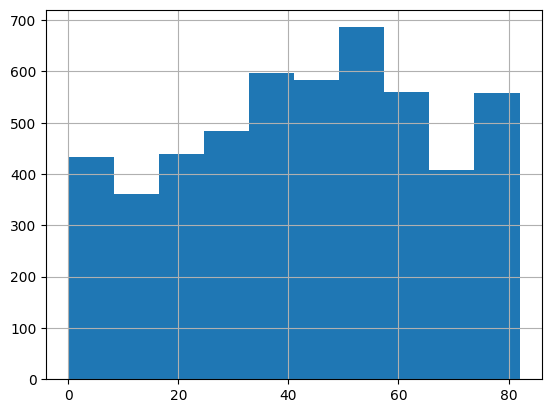

In [9]:
# Visualizing the age variable column.

df['age'].hist()

The age distribution within the age range seems to be fairly normally distributed. However, most datapoints represents 40-60 age range.

In [13]:
# Exploring ages less than five to determine extent of float data types in this column.

df_les_5 = df[df['age']<5]
df_les_5['age']

162     1.32
249     3.00
282     3.00
291     4.00
363     0.64
        ... 
4990    4.00
5032    1.24
5079    1.72
5089    0.72
5095    1.08
Name: age, Length: 255, dtype: float64

It can be seen that there is so much occurence of float data types in the `age` variable column. This may indicate that the dataset includes babies and children of monthly age. The age measurement may be very precise to an extent including years and months.

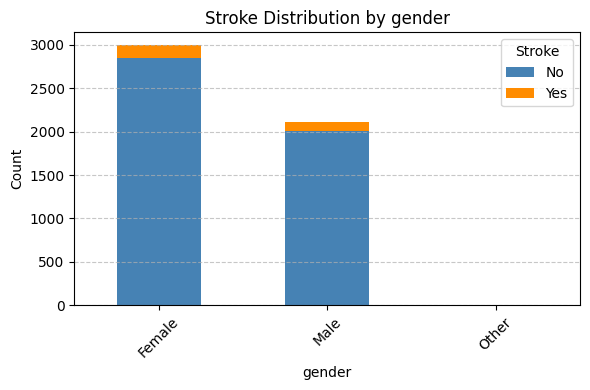

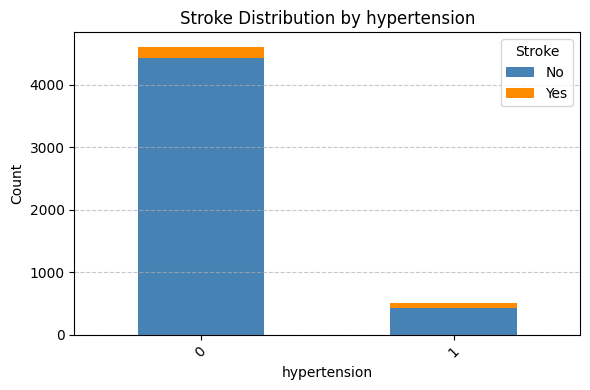

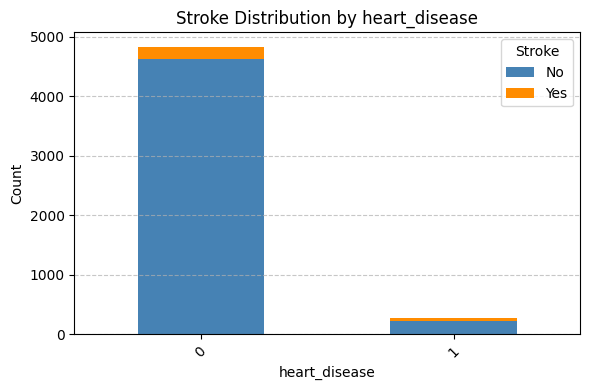

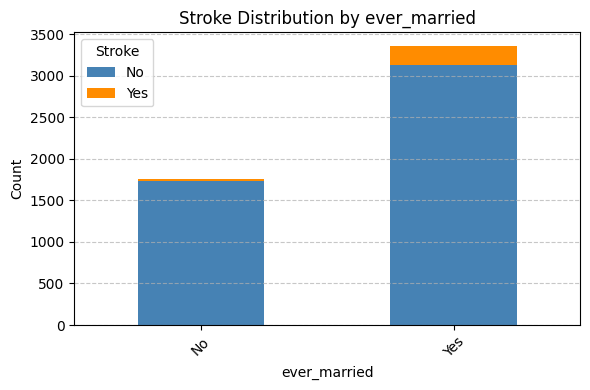

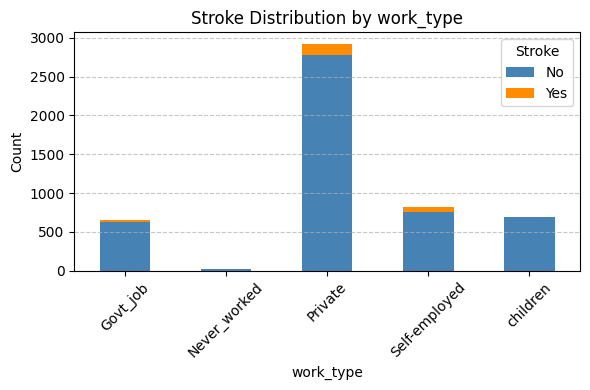

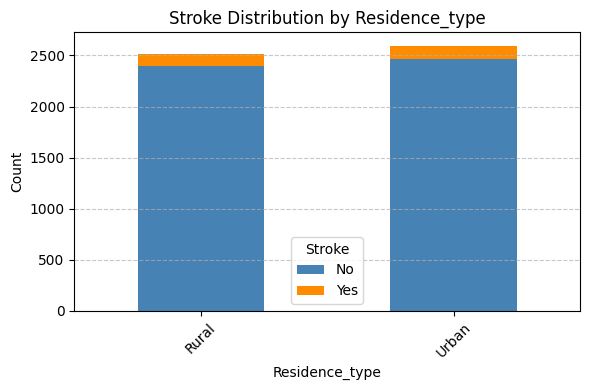

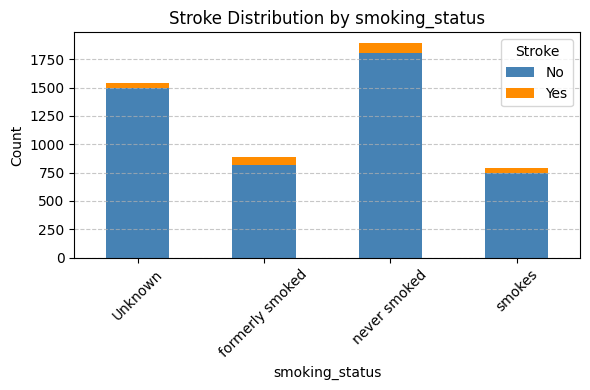

In [40]:
# Visualization of discrete categories against the target variable.

discrete_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                 'work_type', 'Residence_type', 'smoking_status']

for cat in discrete_cols:
    # Cross-tabulate the data
    ct = pd.crosstab(df[cat], df['stroke'])

    # Plot as stacked bar
    ct.plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'], figsize=(6,4))
    plt.title(f'Stroke Distribution by {cat}')
    plt.xlabel(cat)
    plt.ylabel('Count')
    plt.legend(title='Stroke', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
# A visualization function to compare discrete values against target variable.

import pandas as pd
import matplotlib.pyplot as plt

def data_viz(df, cat_col, normalize=False):
    """
    Plots the distribution of the target variable 'stroke' for a given categorical column.

    Parameters:
    - df: pandas DataFrame
    - cat_col: str, name of the categorical column
    - normalize: bool, if True, shows proportion instead of count
    """
    # Create a crosstab of category vs stroke
    ct = pd.crosstab(df[cat_col], df['stroke'], normalize='index' if normalize else False)

    # Plot
    ct.plot(kind='bar', stacked=True, 
            color=['steelblue', 'darkorange'], figsize=(6, 4))
    
    plt.title(f"{'Proportional' if normalize else 'Count'} Distribution of Stroke by '{cat_col}'")
    plt.xlabel(cat_col)
    plt.ylabel('Proportion' if normalize else 'Count')
    plt.legend(title='Stroke', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [41]:
# Tabular form

def data_tb(df, cat_col, normalize=False):
    """
    Returns a crosstab table between a categorical variable and the 'stroke' target column.

    Parameters:
    - df: pandas DataFrame
    - cat_col: column name (str) of the categorical variable
    - normalize: whether to normalize the counts by row (True = show percentages)

    Returns:
    - Crosstab DataFrame
    """
    ct = pd.crosstab(df[cat_col], df['stroke'], normalize='index' if normalize else False)
    return ct


In [46]:
# Stroke vs Hypertension and gender.

print(data_tb(df,'hypertension',normalize=False))
print('\n')
print(data_tb(df,'gender',normalize=False))

stroke           0    1
hypertension           
0             4429  183
1              432   66


stroke     0    1
gender           
Female  2853  141
Male    2007  108
Other      1    0


Hypertension patients are more likely to contract stroke than those without. Surprisingly, stroke is common in female gender than male.

In [48]:
# Stroke vs heart disease and marriage

print(data_tb(df,'heart_disease',normalize=False))
print('\n')
print(data_tb(df,'ever_married',normalize=False))

stroke            0    1
heart_disease           
0              4632  202
1               229   47


stroke           0    1
ever_married           
No            1728   29
Yes           3133  220


Married ones are more likely to contract stroke. Having a heart disease is not so much of a predictor of contracting stroke.

In [50]:
# Stroke vs work type vs residence type vs smoking status.

print(data_tb(df,'work_type',normalize=False))
print('\n')
print(data_tb(df,'Residence_type',normalize=False))
print('\n')
print(data_tb(df,'smoking_status',normalize=False))


stroke            0    1
work_type               
Govt_job        624   33
Never_worked     22    0
Private        2776  149
Self-employed   754   65
children        685    2


stroke             0    1
Residence_type           
Rural           2400  114
Urban           2461  135


stroke              0   1
smoking_status           
Unknown          1497  47
formerly smoked   815  70
never smoked     1802  90
smokes            747  42


People with private jobs catch stroke more. Residence type has no significant difference in determining whether one will catch stroke. Surprisingly, people who never smoked have a higher chance of contracting stroke than those who smoke.

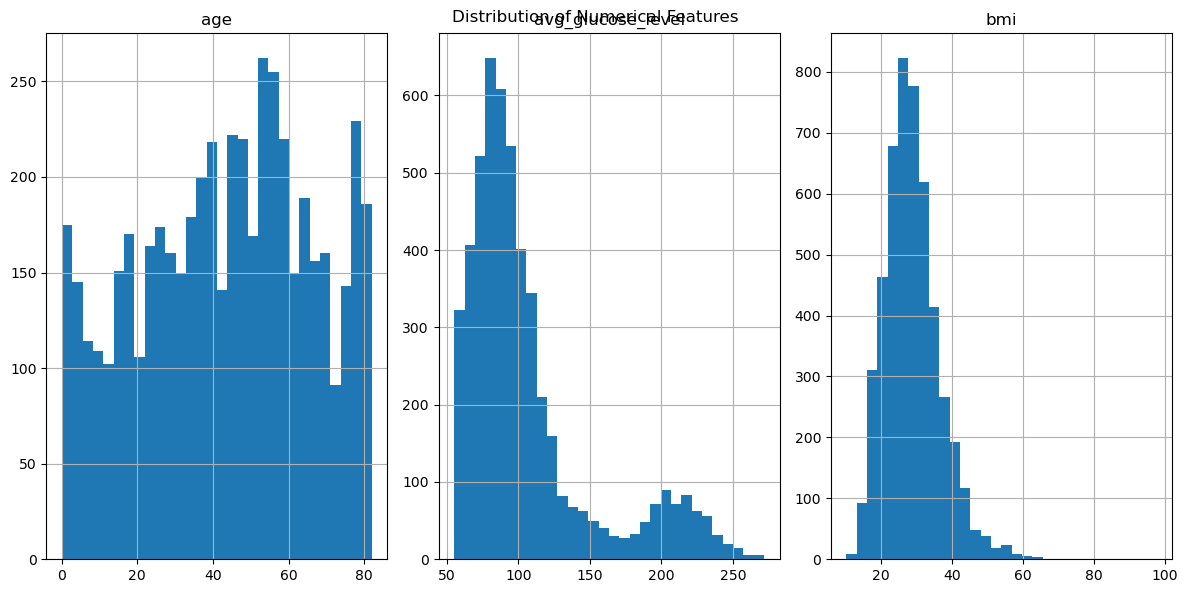

In [23]:
# Visualization of numeric distributions
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols].hist(bins=30, figsize=(12, 6), layout=(1, 3))
plt.tight_layout()
plt.suptitle("Distribution of Numerical Features")
plt.show()

**avg_glucose_level** is skewed to the left whilst **bmi** shows a normal distribution.

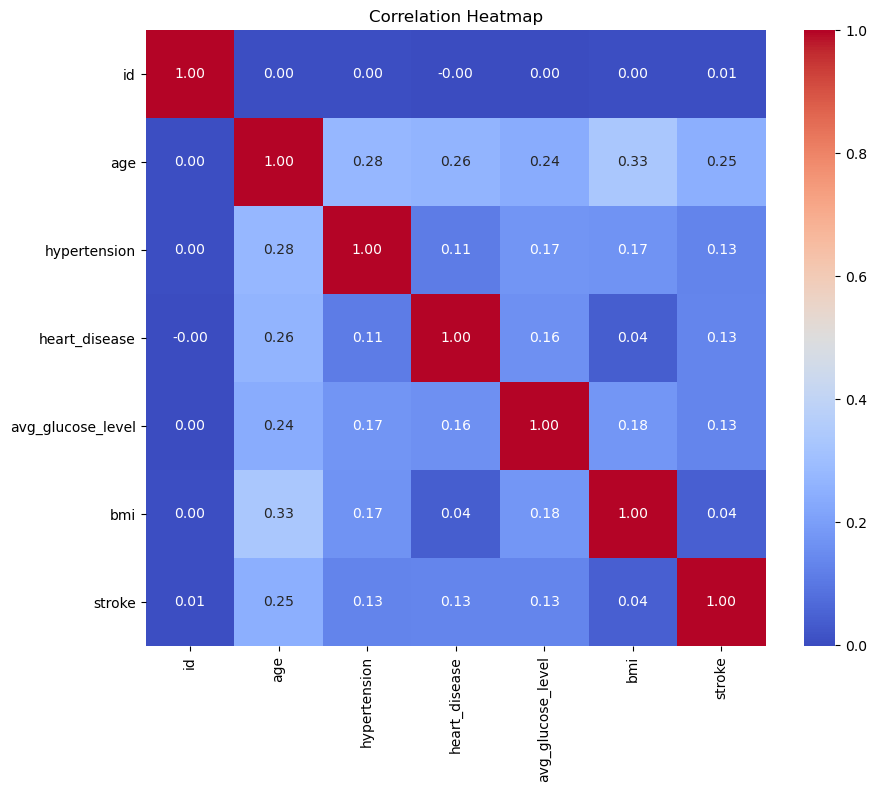

In [24]:
# 5. Correlation heatmap
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Preprocessing

In [25]:
# Irrelevant columns dropped
df.drop('id', axis=1, inplace=True)

# Handling missing values
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [26]:
# Binary variables encoding
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# 'gender' (Male: 0, Female: 1, Other: 2)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})

# One-hot encoding 'work_type' and 'smoking_status'
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)

In [27]:
# Feature-target split
X = df.drop('stroke', axis=1)
y = df['stroke']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Shape confirmation
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4088, 15), y_train shape: (4088,)
X_test shape: (1022, 15), y_test shape: (1022,)


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1609: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

### Creating pytorch dataset and dataloader

In [28]:
# Custom Dataset class
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)  # float32 for BCEWithLogitsLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
# training and test data
train_dataset = StrokeDataset(X_train, y_train)
test_dataset = StrokeDataset(X_test, y_test)

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Quick check
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 128, Test batches: 32


In [30]:
# Model class construction.

class SimpleNeuralLogistic(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNeuralLogistic, self).__init__()

        self.hidden = nn.Linear(input_dim, 16)  # One hidden layer
        self.activation = nn.ReLU()
        self.output = nn.Linear(16, 1)  # Output layer (1 node for binary classification)

        self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_normal_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.kaiming_normal_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)  # Output raw logits (no sigmoid)
        return x


In [32]:
# Initialize the model
input_dim = X_train.shape[1]
model = SimpleNeuralLogistic(input_dim)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Display the model
print(model)


SimpleNeuralLogistic(
  (hidden): Linear(in_features=15, out_features=16, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
# Training loop
epochs = 30
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    train_preds, train_targets = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = torch.sigmoid(outputs).round()
        train_preds += preds.detach().cpu().numpy().tolist()
        train_targets += y_batch.cpu().numpy().tolist()

    # Eval mode
    model.eval()
    epoch_test_loss = 0
    test_preds, test_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            epoch_test_loss += loss.item()

            preds = torch.sigmoid(outputs).round()
            test_preds += preds.cpu().numpy().tolist()
            test_targets += y_batch.cpu().numpy().tolist()

    # Metrics
    train_acc = accuracy_score(train_targets, train_preds)
    test_acc = accuracy_score(test_targets, test_preds)

    train_losses.append(epoch_train_loss / len(train_loader))
    test_losses.append(epoch_test_loss / len(test_loader))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} — "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} — "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.4f}")


*High and stable test accuracy:* It reached ~95.2% test accuracy by epoch 2 and maintained it.

*No overfitting:* Training and test loss both steadily decrease and then stabilize — a great sign.

*Smooth convergence:* Loss stabilizes without oscillations, showing the model has learned well.

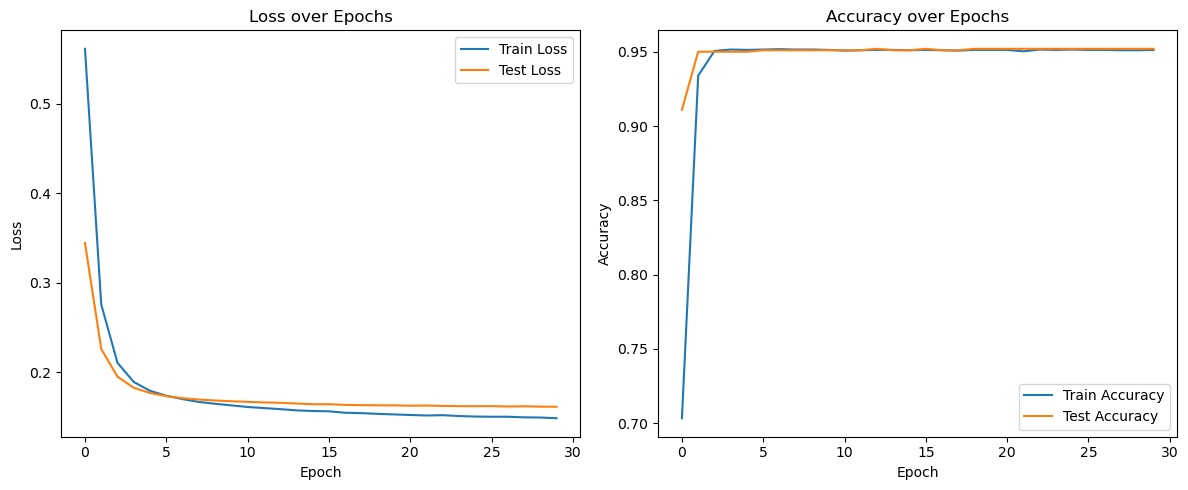

In [34]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


This model performs well and is ready to be deployed.